In [1]:
%load_ext autoreload
%autoreload 2

# Data Loading and Setup

## Import Libraries

In [56]:
# Data manipulation
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
import statsmodels.api as sm
from scipy import stats

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
)

# Settings
%matplotlib inline
sns.set_style('whitegrid')

# Add src to the system path to access utility functions
import sys
import re
import logging
from pathlib import Path
sys.path.append(str(Path().resolve().parent / 'src'))

# Import your custom functions from data_utils.py
from utils.utils import setup_logging
from data.data_utils import load_data, iterative_imputation

## Configuration

In [3]:
# Set up logging
setup_logging("INFO")

# Set up random seed
my_random_seed = '19770525'
np.random.seed(my_random_seed)

# Define file path and columns
raw_data_path = '../data/raw/test_project_data.csv'
categorical_columns = [
    'subject_id', 
    'sex',
    'prevalent_diabetes', 
    'incident_diabetes'
]
numeric_columns = [
    'age', 
    'BMI', 
    'diabetes_followup_time'
]
biomarker_pattern = '^mtb_'


## Load Dataset

In [4]:
# Load data with `pyarrow` (4x faster)
raw_df = load_data(
    raw_data_path = raw_data_path, 
    categorical_columns = categorical_columns, 
    numeric_columns = numeric_columns, 
    biomarker_pattern = biomarker_pattern
)

# Display the first few rows of the dataset
logging.info("Dataset preview:")
raw_df.head()

2024-09-20 20:33:34,409 - INFO - Dataset shape: (8291, 10007)
2024-09-20 20:33:34,412 - INFO - Dataset preview:


,subject_id,mtb_0018261,mtb_0018266,mtb_0018325,mtb_0018326,mtb_0018327,mtb_0018351,mtb_0018362,mtb_0018470,mtb_0018509,...,mtb_2127305,mtb_2129124,mtb_2129210,mtb_2129554,BMI,age,sex,prevalent_diabetes,incident_diabetes,diabetes_followup_time
0,sbj_0000,5885.011,15177.95,19653.31,12611.670,9042.063,NaN,60124.56,9552.881,NaN,...,NaN,NaN,22112.25,NaN,18.664268,33.81,male,0.0,0.0,14.77
1,sbj_0001,7624.425,10901.94,12129.36,9336.460,21680.930,NaN,83700.80,15068.120,NaN,...,NaN,NaN,NaN,NaN,28.175977,68.56,male,0.0,0.0,14.77
2,sbj_0002,7220.400,18086.69,23707.55,7344.697,26314.650,NaN,82482.38,13911.300,NaN,...,15185.790,NaN,19425.35,NaN,22.971959,55.68,male,0.0,0.0,14.77
3,sbj_0003,6797.486,12364.85,17775.76,25836.150,30563.140,NaN,92839.12,11690.130,NaN,...,NaN,NaN,NaN,NaN,21.960370,43.89,female,0.0,0.0,14.78
4,sbj_0004,NaN,19046.33,18701.06,14137.270,27020.920,NaN,85453.69,9579.896,NaN,...,5318.547,NaN,NaN,NaN,40.454949,47.76,male,0.0,0.0,14.86


In [37]:
X_imputed_df = pd.read_pickle("240920_X_imputed_df_10.pkl")

In [35]:
rf_X_imputed_df = pd.read_pickle("240920_rf_X_imputed_df.pkl")

In [ ]:
# X_imputed_df = pd.read_pickle("240920_X_imputed_df.pkl")

In [11]:
# explore missingess pattern.
# cleaned_df_corr = cleaned_df.drop(columns = ["subject_id", "incident_diabetes", "diabetes_followup_time"]).corr()

# Data Preprocessing

## Data Overview

In [ ]:
# Calculate missingness rate for each column
missingness_rate = (
    raw_df.isnull()
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
missingness_rate.columns = ['column', 'missing_rate']

# Filter columns with >30% missingness
filtered_missingness = missingness_rate[
    missingness_rate['missing_rate'] > 0.30
]

# Display or return the filtered missingness DataFrame
filtered_missingness

In [ ]:
# missing_corr = raw_df.isnull().corr()
# sns.heatmap(missing_corr, cmap="coolwarm", annot=True)

## Encode Categorical Data

In [ ]:
raw_df['sex'] = raw_df['sex'].map({'male': 1, 'female': 0})
raw_df['incident_diabetes'] = raw_df['incident_diabetes'].map({1.0: 1, 0.0: 0})
raw_df['prevalent_diabetes'] = raw_df['prevalent_diabetes'].map({1.0: 1, 0.0: 0})

/tmp/ipykernel_101631/2264171592.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cleaned_df['propensity_score'] = propensity_model.predict_proba(X_scaled)[:, 1]


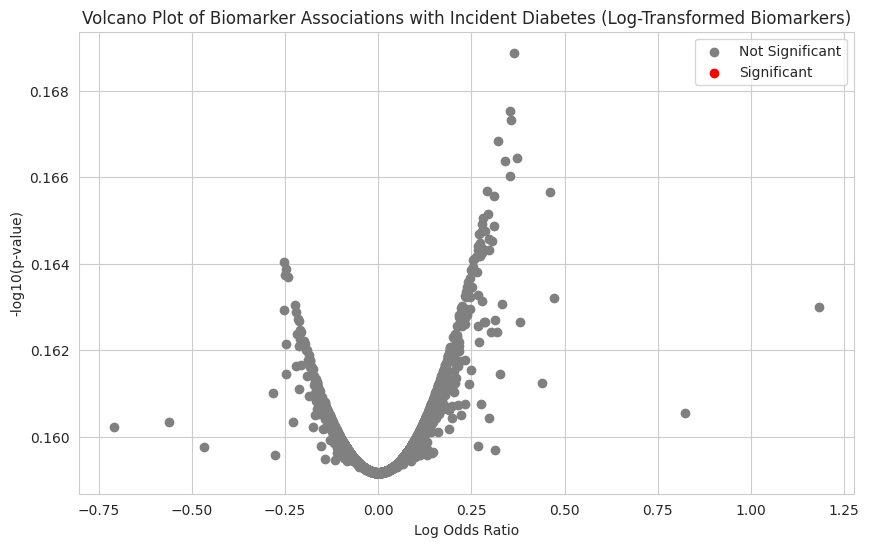

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import log_loss
from statsmodels.stats.multitest import multipletests

# Step 1: Prepare the data and log-transform biomarkers
cleaned_df = X_imputed_df.dropna(subset=['incident_diabetes']).copy()

# Apply log transformation to biomarkers with a small constant to avoid log(0) issues
biomarker_cols = [col for col in cleaned_df.columns if col.startswith('mtb_')]
cleaned_df[biomarker_cols] = cleaned_df[biomarker_cols].apply(lambda x: np.expm1(x))

# cleaned_df[biomarker_cols] = np.log(cleaned_df[biomarker_cols] + 1e-6)

# Step 2: Propensity Score Calculation (excluding 'diabetes_followup_time')
covariates = ['age', 'sex', 'BMI']
X = cleaned_df[covariates]
y = cleaned_df['incident_diabetes']

# Standardize covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Logistic regression for propensity score calculation
propensity_model = LogisticRegression(solver='liblinear')
propensity_model.fit(X_scaled, y)
cleaned_df['propensity_score'] = propensity_model.predict_proba(X_scaled)[:, 1]

# Step 3: Propensity Score Matching
cases = cleaned_df[cleaned_df['incident_diabetes'] == 1].copy()
controls = cleaned_df[cleaned_df['incident_diabetes'] == 0].copy()

# Perform 1-to-1 nearest neighbor matching on propensity scores
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(controls[['propensity_score']])
distances, indices = nbrs.kneighbors(cases[['propensity_score']])

# Get matched controls
matched_controls = controls.iloc[indices.flatten()]
matched_data = pd.concat([cases, matched_controls], ignore_index=True)

# Step 4: Logistic Regression for Biomarkers Using sklearn
results = []

for biomarker in biomarker_cols:
    X_biomarker = matched_data[[biomarker]] #  + covariates]
    y_biomarker = matched_data['incident_diabetes']
    
    # Standardize biomarker data
    X_biomarker_scaled = scaler.fit_transform(X_biomarker)

    # Logistic regression with sklearn
    log_reg = LogisticRegression(solver='liblinear')
    log_reg.fit(X_biomarker_scaled, y_biomarker)
    
    # Get log odds ratio (coefficient) and p-value approximation using log loss
    log_odds = log_reg.coef_[0][0]
    pred_probs = log_reg.predict_proba(X_biomarker_scaled)[:, 1]
    p_value_approx = log_loss(y_biomarker, pred_probs)  # Approximation
    
    results.append((biomarker, log_odds, p_value_approx))

# Step 5: Results and Multiple Testing Correction
results_df = pd.DataFrame(results, columns=['biomarker', 'log_odds', 'p_value'])
results_df['adjusted_p_value'] = multipletests(results_df['p_value'], method='bonferroni')[1]
results_df['-log10(p_value)'] = -np.log10(results_df['p_value'])

# Step 6: Volcano Plbot
plt.figure(figsize=(10, 6))
plt.scatter(results_df['log_odds'], results_df['-log10(p_value)'], color='gray', label='Not Significant')
significant = results_df[results_df['adjusted_p_value'] < 0.05]
plt.scatter(significant['log_odds'], significant['-log10(p_value)'], color='red', label='Significant')

# plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')

plt.xlabel('Log Odds Ratio')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot of Biomarker Associations with Incident Diabetes (Log-Transformed Biomarkers)')
plt.legend()
plt.show()


In [64]:
np.max(raw_df[biomarker_cols])

1788917000.0

In [65]:
np.min(raw_df[biomarker_cols])

59.9017

In [59]:
np.log(cleaned_df[biomarker_cols] + 1e-6)

/opt/applications/python/3.8.3/gnu/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,mtb_0018261,mtb_0018266,mtb_0018325,mtb_0018362,mtb_0018536,mtb_0018607,mtb_0018878,mtb_0018885,mtb_0018973,mtb_0018978,...,mtb_1982264,mtb_1985184,mtb_1986979,mtb_1991935,mtb_1999877,mtb_2002573,mtb_2037028,mtb_2039709,mtb_2111898,mtb_2126559
0,8.680164,9.627599,9.886001,11.004174,10.751604,8.577013,10.336887,10.367959,11.009191,10.515459,...,10.176625,10.051651,8.729284,9.169964,9.641358,9.790245,9.866799,10.684644,9.617268,9.355147
1,8.939112,9.296696,9.403384,11.335004,9.986427,9.955321,11.008511,10.779627,11.349177,10.679522,...,10.524157,10.943651,8.678637,10.037381,9.136196,9.319922,9.808190,9.854598,9.977654,9.674023
2,8.884666,9.802932,10.073549,11.320340,10.013264,10.189831,10.596545,10.778444,11.313470,11.134310,...,10.190048,9.687014,8.053950,9.222520,9.451250,9.609330,9.132138,10.707728,9.540383,9.425066
3,8.824308,9.422613,9.785591,11.438623,9.247065,9.132618,10.857818,10.453190,11.596325,10.488633,...,10.619327,10.279287,8.691879,9.279895,9.606173,9.382263,9.365850,10.994347,10.101329,9.788061
4,8.833694,9.854630,9.836336,11.355730,9.661468,10.353750,11.143880,10.609963,11.492029,10.821756,...,10.469752,10.905642,8.612607,9.859940,9.503582,9.599566,9.786771,10.622225,9.983533,9.720174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8286,9.238221,8.886945,8.721886,11.016575,10.848915,9.797630,11.131188,10.375435,10.730689,10.921354,...,9.533203,9.766634,8.626165,8.078934,9.330788,8.851478,8.465711,9.667597,9.583731,8.982088
8287,9.141523,10.296794,8.827523,11.028530,9.554657,9.921169,10.629790,10.112298,10.221605,10.657901,...,9.810951,10.297585,8.436554,9.553341,9.097826,8.762406,8.601099,10.348028,9.920630,9.014533
8288,9.213997,10.468747,9.297814,11.146907,9.267390,9.906308,10.409414,9.969243,10.735356,10.977229,...,9.849558,10.020202,8.286351,9.015393,8.767101,9.096195,8.357987,9.654556,9.979463,9.119646
8289,9.097455,8.569903,8.844847,11.121467,10.283405,10.650351,10.528820,10.437132,11.533226,10.834352,...,9.791177,9.154170,8.149722,7.936756,8.580879,8.853686,9.303680,9.749821,9.305850,9.019457


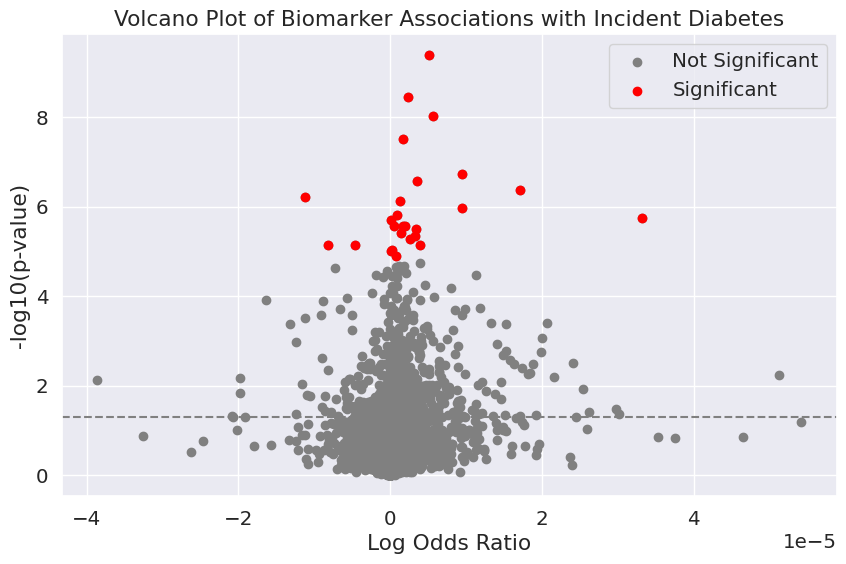

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors

cleaned_df = X_imputed_df.dropna(subset=['incident_diabetes']).copy()

# Step 1: Propensity Score Calculation (excluding 'diabetes_followup_time')
covariates = ['age', 'sex', 'BMI']
X = cleaned_df[covariates]
y = cleaned_df['incident_diabetes']

# Standardize covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Logistic regression for propensity score calculation
propensity_model = LogisticRegression(solver='liblinear')
propensity_model.fit(X_scaled, y)
cleaned_df['propensity_score'] = propensity_model.predict_proba(X_scaled)[:, 1]

# Step 2: Propensity Score Matching
cases = cleaned_df[cleaned_df['incident_diabetes'] == 1]
controls = cleaned_df[cleaned_df['incident_diabetes'] == 0]

# Perform 1-to-1 nearest neighbor matching
nbrs = NearestNeighbors(n_neighbors=1).fit(controls[['propensity_score']])
distances, indices = nbrs.kneighbors(cases[['propensity_score']])

# Get matched controls
matched_controls = controls.iloc[indices.flatten()]
matched_data = pd.concat([cases, matched_controls], ignore_index=True)

# Step 3: Logistic Regression for Biomarkers
biomarker_cols = [col for col in cleaned_df.columns if col.startswith('mtb_')]
results = []

for biomarker in biomarker_cols:
    X_biomarker = matched_data[[biomarker] + covariates]
    X_biomarker = sm.add_constant(X_biomarker)  # Add intercept
    y_biomarker = matched_data['incident_diabetes']

    model = sm.Logit(y_biomarker, X_biomarker)
    result = model.fit(disp=0)
    
    p_value = result.pvalues[biomarker]
    coef = result.params[biomarker]
    
    results.append((biomarker, coef, p_value))

# Step 4: Results and Multiple Testing Correction
results_df = pd.DataFrame(results, columns=['biomarker', 'log_odds', 'p_value'])
results_df['adjusted_p_value'] = multipletests(results_df['p_value'], method='bonferroni')[1]
results_df['-log10(p_value)'] = -np.log10(results_df['p_value'])

# Step 5: Volcano Plot
plt.figure(figsize=(10, 6))
plt.scatter(results_df['log_odds'], results_df['-log10(p_value)'], color='gray', label='Not Significant')
significant = results_df[results_df['adjusted_p_value'] < 0.05]
plt.scatter(significant['log_odds'], significant['-log10(p_value)'], color='red', label='Significant')

plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')

plt.xlabel('Log Odds Ratio')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot of Biomarker Associations with Incident Diabetes')
plt.legend()
plt.show()


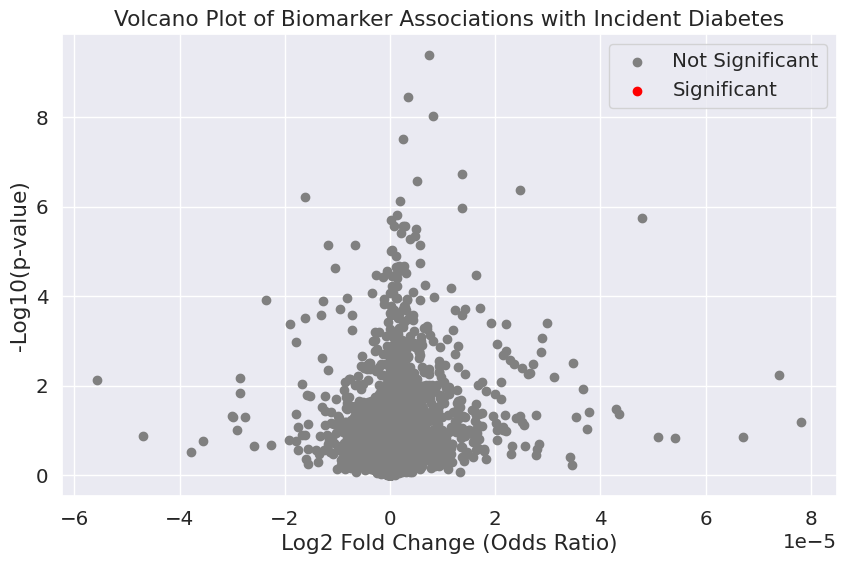

In [48]:
from statsmodels.stats.multitest import multipletests

# Step 4: Results and Multiple Testing Correction
results_df = pd.DataFrame(results, columns=['biomarker', 'log_odds', 'p_value'])

# Apply Benjamini-Hochberg (FDR) correction instead of Bonferroni
results_df['adjusted_p_value'] = multipletests(results_df['p_value'], method='fdr_bh')[1]
results_df['-log10(p_value)'] = -np.log10(results_df['p_value'])

# Calculate Log2 Fold Change from Log Odds
results_df['log2FC'] = np.log2(np.exp(results_df['log_odds']))  # Approximation

# Define thresholds for significance and fold change
pval_threshold = -np.log10(0.05)  # p-value < 0.05 (after adjustment)
fc_threshold = 1  # Log2 fold change threshold

# Step 5: Volcano Plot
plt.figure(figsize=(10, 6))

# Plot non-significant points in gray
plt.scatter(results_df['log2FC'], results_df['-log10(p_value)'], color='gray', label='Not Significant')

# Highlight significant points (red) based on both p-value and fold change
significant = results_df[(results_df['-log10(p_value)'] > pval_threshold) & (abs(results_df['log2FC']) > fc_threshold)]
plt.scatter(significant['log2FC'], significant['-log10(p_value)'], color='red', label='Significant')

# Add threshold lines for p-value and fold change
# plt.axhline(y=pval_threshold, color='blue', linestyle='--', label='p = 0.05')
# plt.axvline(x=fc_threshold, color='blue', linestyle='--', label='Log2FC = 1')
# plt.axvline(x=-fc_threshold, color='blue', linestyle='--')

# Add titles and labels
plt.title('Volcano Plot of Biomarker Associations with Incident Diabetes')
plt.xlabel('Log2 Fold Change (Odds Ratio)')
plt.ylabel('-Log10(p-value)')
plt.legend()
plt.show()


In [45]:
matched_data

,subject_id,mtb_0018261,mtb_0018266,mtb_0018325,mtb_0018362,mtb_0018536,mtb_0018607,mtb_0018878,mtb_0018885,mtb_0018973,...,mtb_2039709,mtb_2111898,mtb_2126559,BMI,age,sex,prevalent_diabetes,incident_diabetes,diabetes_followup_time,propensity_score
0,sbj_0008,6381.261230,11864.459961,9896.124023,78010.898438,30909.519531,10405.540039,72263.726562,36416.171875,88696.882812,...,35831.988281,14993.990234,14693.990234,32.996552,32.730000,1.0,0.0,1.0,7.88,0.136198
1,sbj_0018,7601.316895,5131.670898,5918.784180,18516.410156,35119.089844,7007.433105,38142.750000,4566.234863,13429.719727,...,67409.203125,19463.810547,17691.880859,31.328312,61.360001,1.0,0.0,1.0,8.55,0.194970
2,sbj_0020,7540.104980,4329.825195,6862.309082,61724.640625,9278.663086,8002.506836,40018.109375,24651.900391,62074.750000,...,30922.689453,14962.929688,15060.219727,34.069881,56.790001,0.0,0.0,1.0,6.49,0.173648
3,sbj_0026,16382.778320,38482.011719,30162.619141,428960.812500,163075.093750,28014.039062,93550.531250,226490.703125,291048.312500,...,18932.085938,7806.971191,5537.907227,28.360741,49.930000,1.0,0.0,1.0,8.17,0.101608
4,sbj_0039,14643.620117,32165.109375,15535.209961,227746.703125,227861.703125,30115.238281,56067.210938,80657.289062,197254.500000,...,8739.884766,13069.059570,4366.430176,29.076582,53.009998,1.0,0.0,1.0,6.46,0.120478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,sbj_6977,9567.370117,10815.830078,12559.719727,66523.828125,17370.640625,19741.119141,38602.121094,36431.671875,73953.632812,...,20674.820312,24730.109375,20841.029297,29.166666,72.879997,1.0,0.0,0.0,12.05,0.184316
1404,sbj_8004,9659.563477,29089.160156,16174.809570,58096.300781,17525.500000,13705.000000,33253.929688,36370.164062,31616.380859,...,17992.269531,25816.109375,7628.962891,25.873734,36.480000,0.0,1.0,0.0,NaN,0.032682
1405,sbj_4586,7684.163086,21726.460938,11115.290039,67991.968750,21729.980469,16458.050781,36418.070312,27651.839844,40867.808594,...,24915.519531,13249.629883,5203.890137,28.483509,59.910000,1.0,0.0,0.0,14.89,0.128365
1406,sbj_2119,8507.751953,16596.259766,14498.019531,47723.039062,7854.383789,20221.890625,33999.191406,23887.839844,29508.750000,...,23178.226562,21357.470703,3814.745117,34.861431,61.419998,1.0,1.0,0.0,-0.87,0.300948


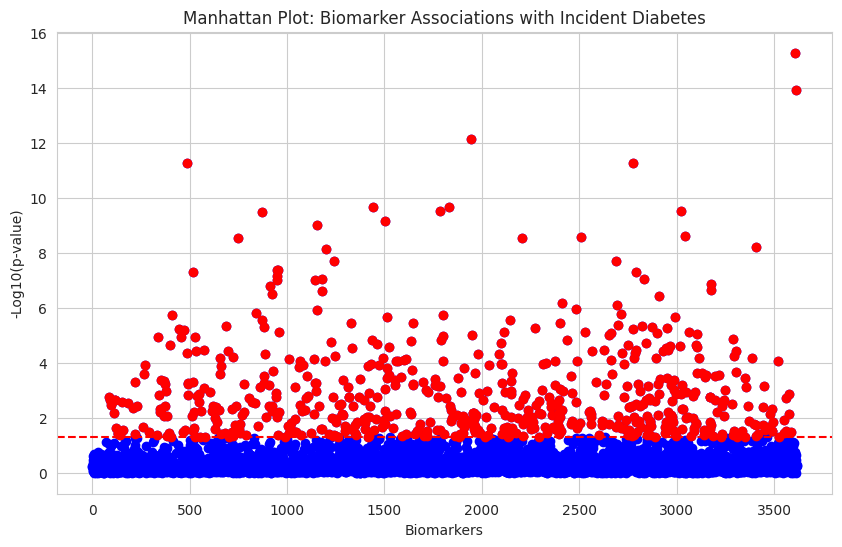

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

# Assuming raw_df is your original DataFrame
# Drop rows with missing values in 'incident_diabetes'
cleaned_df = X_imputed_df.dropna(subset=['incident_diabetes'])

# Selecting biomarker columns (assuming they start with 'mtb_')
biomarker_cols = [col for col in cleaned_df.columns if col.startswith('mtb_')]

# Include age, sex, and BMI as covariates
covariates = ['age', 'sex', 'BMI']
y = cleaned_df['incident_diabetes']

# Create lists to store p-values
p_values = []

# Loop through each biomarker and fit a separate model
for biomarker in biomarker_cols:
    # Create a dataframe with the biomarker and covariates
    X = cleaned_df[[biomarker] + covariates]
    X = sm.add_constant(X)  # Add constant for intercept
    
    # Fit logistic regression model
    logit_model = sm.Logit(y, X)
    result = logit_model.fit(disp=0)
    
    # Store the p-value for the biomarker
    p_values.append(result.pvalues[1])  # p-value for the biomarker (skip the constant)

# Adjust p-values for multiple testing (using Benjamini-Hochberg)
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# -log10(corrected p-values) for Manhattan plot
neg_log_p_values = -np.log10(corrected_p_values)

# Create a DataFrame for plotting
manhattan_data = pd.DataFrame({
    'Biomarker': biomarker_cols,
    '-log10(p-value)': neg_log_p_values
})

# Plotting the Manhattan plot
plt.figure(figsize=(10, 6))
plt.scatter(x=range(len(manhattan_data)), y=manhattan_data['-log10(p-value)'], color='blue')

# Add significance threshold line (for p-value < 0.05)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')

# Titles and labels
plt.title('Manhattan Plot: Biomarker Associations with Incident Diabetes')
plt.xlabel('Biomarkers')
plt.ylabel('-Log10(p-value)')

# Highlight significant biomarkers (adjusted p-value < 0.05)
sig_biomarkers = manhattan_data[manhattan_data['-log10(p-value)'] > -np.log10(0.05)]
plt.scatter(sig_biomarkers.index, sig_biomarkers['-log10(p-value)'], color='red')

plt.show()


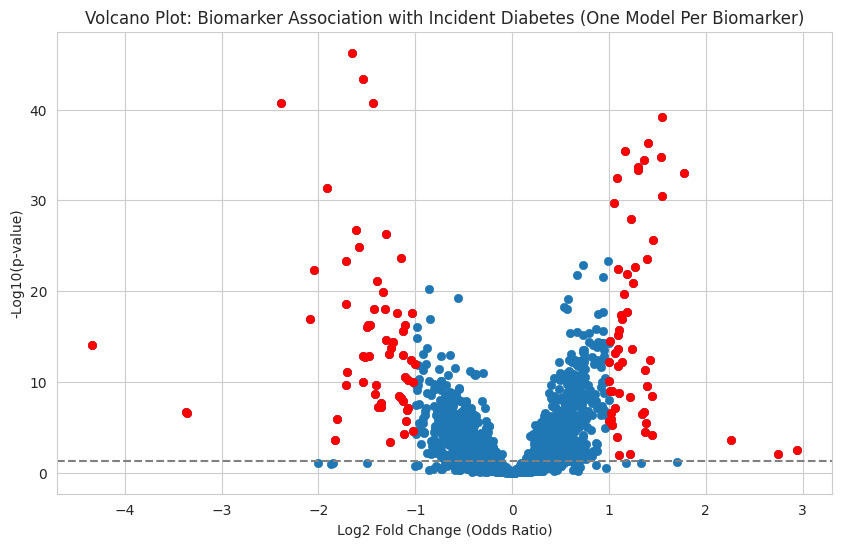

In [31]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

# Assuming raw_df is your original DataFrame
# Drop rows with missing values in 'incident_diabetes'
cleaned_df = X_imputed_df.dropna(subset=['incident_diabetes'])

# Selecting biomarker columns (assuming they start with 'mtb_')
biomarker_cols = [col for col in cleaned_df.columns if col.startswith('mtb_')]

# Include age, sex, and BMI as covariates
covariates = ['age', 'sex'] # , 'BMI']
y = cleaned_df['incident_diabetes']

# Create lists to store results
log2_fold_changes = []
p_values = []

# Loop through each biomarker and fit a separate model
for biomarker in biomarker_cols:
    # Create a dataframe with the biomarker and covariates
    X = cleaned_df[[biomarker] + covariates]
    X = sm.add_constant(X)  # Add constant for intercept
    
    # Fit logistic regression model
    logit_model = sm.Logit(y, X)
    result = logit_model.fit(disp=0)
    
    # Store the log2 fold change and p-value for the biomarker
    odds_ratio = np.exp(result.params[1])  # Odds ratio for the biomarker (skip the constant)
    log2_fold_changes.append(np.log2(odds_ratio))  # Log2 fold change
    p_values.append(result.pvalues[1])  # p-value for the biomarker

# Adjust p-values for multiple testing (using Benjamini-Hochberg)
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# -log10(corrected p-values) for volcano plot
neg_log_p_values = -np.log10(corrected_p_values)

# Create a DataFrame for plotting
volcano_data = pd.DataFrame({
    'log2FC': log2_fold_changes,
    '-log10(p-value)': neg_log_p_values
})

# Plotting the volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=volcano_data, x='log2FC', y='-log10(p-value)', edgecolor=None)

# Define thresholds for significance and fold change
pval_threshold = -np.log10(0.05)  # p-value < 0.05 (after adjustment)
fc_threshold = 1  # Log2 fold change threshold

# Highlight significant points
sig = volcano_data[(volcano_data['-log10(p-value)'] > pval_threshold) & (abs(volcano_data['log2FC']) > fc_threshold)]
sns.scatterplot(data=sig, x='log2FC', y='-log10(p-value)', color='red', edgecolor=None)

# Add threshold lines
plt.axhline(y=pval_threshold, color='grey', linestyle='--')
# plt.axvline(x=fc_threshold, color='grey', linestyle='--')
# plt.axvline(x=-fc_threshold, color='grey', linestyle='--')

# Titles and labels
plt.title('Volcano Plot: Biomarker Association with Incident Diabetes (One Model Per Biomarker)')
plt.xlabel('Log2 Fold Change (Odds Ratio)')
plt.ylabel('-Log10(p-value)')
plt.show()


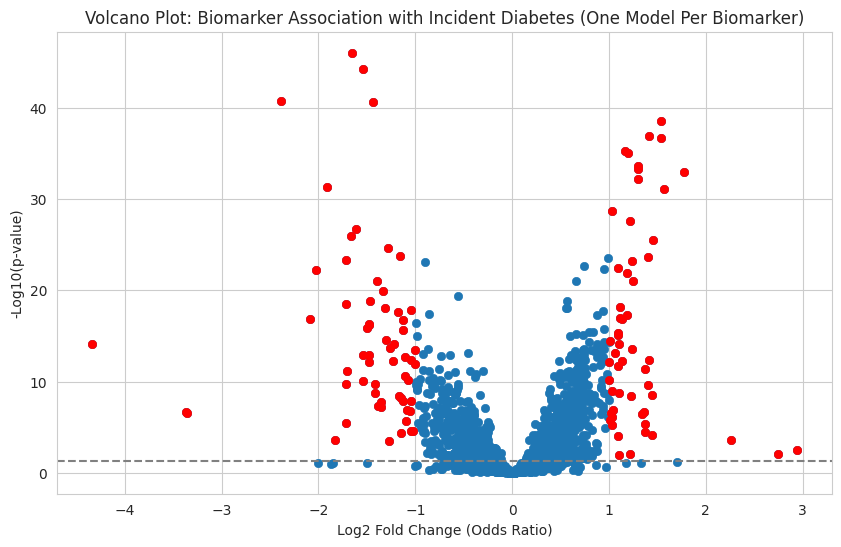

In [42]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

# Assuming raw_df is your original DataFrame
# Drop rows with missing values in 'incident_diabetes'
cleaned_df = X_imputed_df.dropna(subset=['incident_diabetes'])

# Selecting biomarker columns (assuming they start with 'mtb_')
biomarker_cols = [col for col in cleaned_df.columns if col.startswith('mtb_')]

# Include age, sex, and BMI as covariates
covariates = ['age', 'sex'] # , 'BMI']
y = cleaned_df['incident_diabetes']

# Create lists to store results
log2_fold_changes = []
p_values = []

# Loop through each biomarker and fit a separate model
for biomarker in biomarker_cols:
    # Create a dataframe with the biomarker and covariates
    X = cleaned_df[[biomarker] + covariates]
    X = sm.add_constant(X)  # Add constant for intercept
    
    # Fit logistic regression model
    logit_model = sm.Logit(y, X)
    result = logit_model.fit(disp=0)
    
    # Store the log2 fold change and p-value for the biomarker
    odds_ratio = np.exp(result.params[1])  # Odds ratio for the biomarker (skip the constant)
    log2_fold_changes.append(np.log2(odds_ratio))  # Log2 fold change
    p_values.append(result.pvalues[1])  # p-value for the biomarker

# Adjust p-values for multiple testing (using Benjamini-Hochberg)
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# -log10(corrected p-values) for volcano plot
neg_log_p_values = -np.log10(corrected_p_values)

# Create a DataFrame for plotting
volcano_data = pd.DataFrame({
    'log2FC': log2_fold_changes,
    '-log10(p-value)': neg_log_p_values
})

# Plotting the volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=volcano_data, x='log2FC', y='-log10(p-value)', edgecolor=None)

# Define thresholds for significance and fold change
pval_threshold = -np.log10(0.05)  # p-value < 0.05 (after adjustment)
fc_threshold = 1  # Log2 fold change threshold

# Highlight significant points
sig = volcano_data[(volcano_data['-log10(p-value)'] > pval_threshold) & (abs(volcano_data['log2FC']) > fc_threshold)]
sns.scatterplot(data=sig, x='log2FC', y='-log10(p-value)', color='red', edgecolor=None)

# Add threshold lines
plt.axhline(y=pval_threshold, color='grey', linestyle='--')
# plt.axvline(x=fc_threshold, color='grey', linestyle='--')
# plt.axvline(x=-fc_threshold, color='grey', linestyle='--')

# Titles and labels
plt.title('Volcano Plot: Biomarker Association with Incident Diabetes (One Model Per Biomarker)')
plt.xlabel('Log2 Fold Change (Odds Ratio)')
plt.ylabel('-Log10(p-value)')
plt.show()


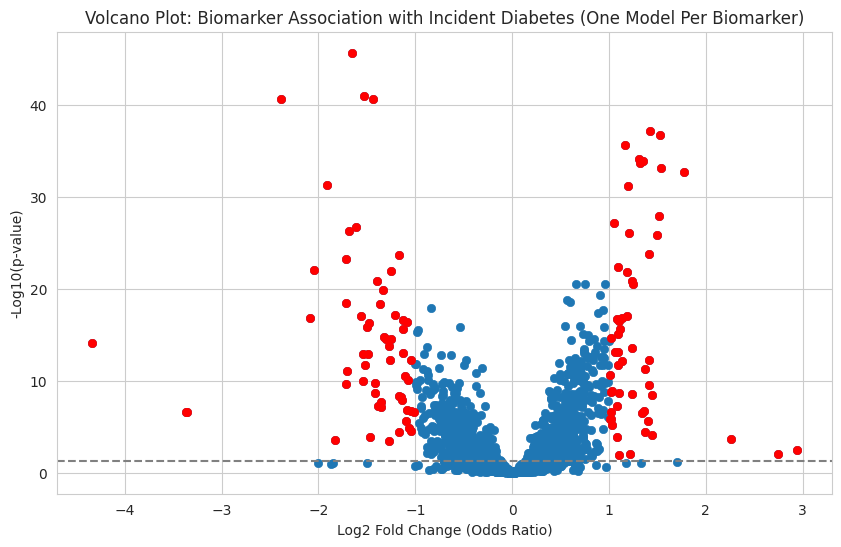

In [43]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

# Assuming raw_df is your original DataFrame
# Drop rows with missing values in 'incident_diabetes'
cleaned_df = rf_X_imputed_df.dropna(subset=['incident_diabetes'])

# Selecting biomarker columns (assuming they start with 'mtb_')
biomarker_cols = [col for col in cleaned_df.columns if col.startswith('mtb_')]

# Include age, sex, and BMI as covariates
covariates = ['age', 'sex'] # , 'BMI']
y = cleaned_df['incident_diabetes']

# Create lists to store results
log2_fold_changes = []
p_values = []

# Loop through each biomarker and fit a separate model
for biomarker in biomarker_cols:
    # Create a dataframe with the biomarker and covariates
    X = cleaned_df[[biomarker] + covariates]
    X = sm.add_constant(X)  # Add constant for intercept
    
    # Fit logistic regression model
    logit_model = sm.Logit(y, X)
    result = logit_model.fit(disp=0)
    
    # Store the log2 fold change and p-value for the biomarker
    odds_ratio = np.exp(result.params[1])  # Odds ratio for the biomarker (skip the constant)
    log2_fold_changes.append(np.log2(odds_ratio))  # Log2 fold change
    p_values.append(result.pvalues[1])  # p-value for the biomarker

# Adjust p-values for multiple testing (using Benjamini-Hochberg)
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# -log10(corrected p-values) for volcano plot
neg_log_p_values = -np.log10(corrected_p_values)

# Create a DataFrame for plotting
volcano_data = pd.DataFrame({
    'log2FC': log2_fold_changes,
    '-log10(p-value)': neg_log_p_values
})

# Plotting the volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=volcano_data, x='log2FC', y='-log10(p-value)', edgecolor=None)

# Define thresholds for significance and fold change
pval_threshold = -np.log10(0.05)  # p-value < 0.05 (after adjustment)
fc_threshold = 1  # Log2 fold change threshold

# Highlight significant points
sig = volcano_data[(volcano_data['-log10(p-value)'] > pval_threshold) & (abs(volcano_data['log2FC']) > fc_threshold)]
sns.scatterplot(data=sig, x='log2FC', y='-log10(p-value)', color='red', edgecolor=None)

# Add threshold lines
plt.axhline(y=pval_threshold, color='grey', linestyle='--')
# plt.axvline(x=fc_threshold, color='grey', linestyle='--')
# plt.axvline(x=-fc_threshold, color='grey', linestyle='--')

# Titles and labels
plt.title('Volcano Plot: Biomarker Association with Incident Diabetes (One Model Per Biomarker)')
plt.xlabel('Log2 Fold Change (Odds Ratio)')
plt.ylabel('-Log10(p-value)')
plt.show()


## Handle Missing Values

### Multivariate Imputation (`MICE`)

In [ ]:
# Perform imputation using the default estimator (no RandomForestRegressor)
imputed_df = iterative_imputation(
    raw_df=raw_df, 
    missing_threshold=0.3,  # Drop columns with >30% missingness
    exclude_cols=[
        'subject_id', 
        'incident_diabetes', 
        'diabetes_followup_time'
    ],  # Excluded from imputation
    imputer_kwargs={
        'max_iter': 3, 
        'n_nearest_features': 50, 
        'random_state': my_random_seed, 
        'verbose': 2
    }
)

X_imputed_df['prevalent_diabetes'] = np.round(X_imputed_df['prevalent_diabetes'])


### (Optional) Random Forest-Based Multivariate Imputation (`miceRanger`)

In [ ]:









# Define the RandomForestRegressor
random_forest_regressor = RandomForestRegressor(
    n_estimators=50, 
    random_state=my_random_seed, 
    n_jobs=-1
)

# Perform imputation with RandomForestRegressor and a custom missing threshold
rf_imputed_df = iterative_imputation(
    raw_df=raw_df, 
    missing_threshold=0.3,  # Drop columns with >30% missingness
    exclude_cols=[
        'subject_id', 
        'incident_diabetes', 
        'diabetes_followup_time'
    ],  # Excluded from imputation
    estimator=random_forest_regressor,  # Custom estimator for imputation
    imputer_kwargs={'max_iter': 3, 
                    'n_nearest_features': 50, 
                    'random_state': my_random_seed, 
                    'verbose': 2
                   }
)


## Transform Biomarkers

In [ ]:
biomarker_cols = [col for col in raw_df.columns if col.startswith('mtb_')]
raw_df[biomarker_cols] = raw_df[biomarker_cols].apply(lambda x: np.log1p(x))

# Exploratory Data Analysis (EDA)

## Demographic Distributions

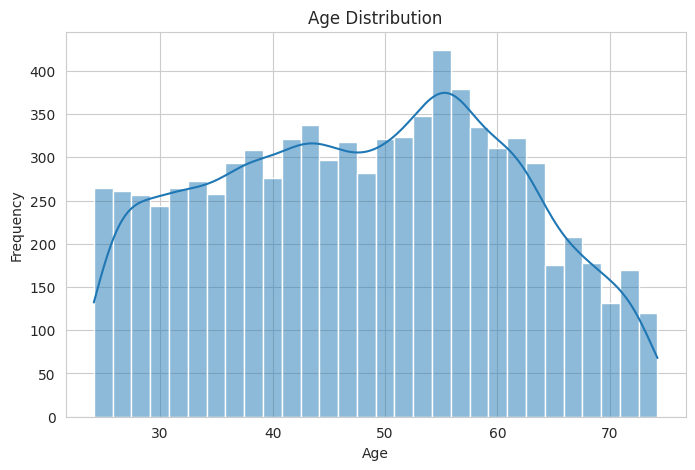

In [21]:
# Age Distribution
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_df['age'], kde=True, bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

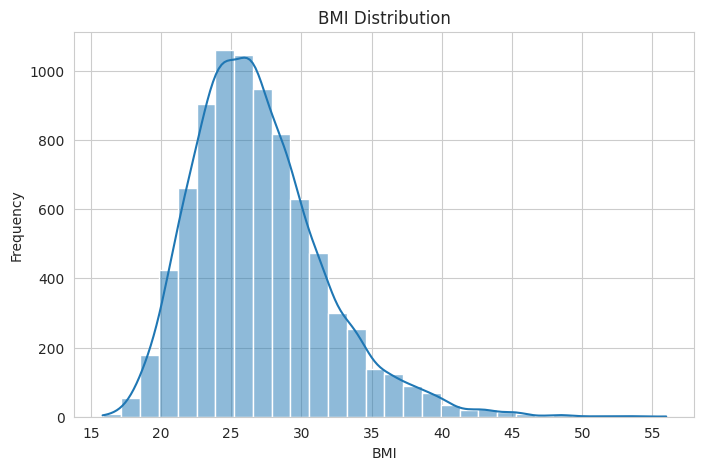

In [22]:
# BMI Distribution
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_df['BMI'], kde=True, bins=30)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

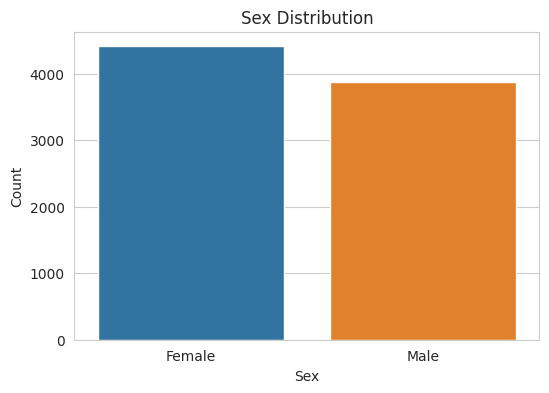

In [43]:
# Sex Distribution

# Plot the original data with numerical values, but set custom x-tick labels
plt.figure(figsize=(6, 4))
sns.countplot(x='sex', data=cleaned_df)
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')

# Set custom labels for the x-axis
plt.xticks([0, 1], ['Female', 'Male'])

plt.show()

## Outcome Variable Analysis

In [44]:
# Incident diabetes rate
incident_rate = cleaned_df['incident_diabetes'].mean()
print(f'Incident Diabetes Rate: {incident_rate * 100:.2f}%')

Incident Diabetes Rate: 8.64%


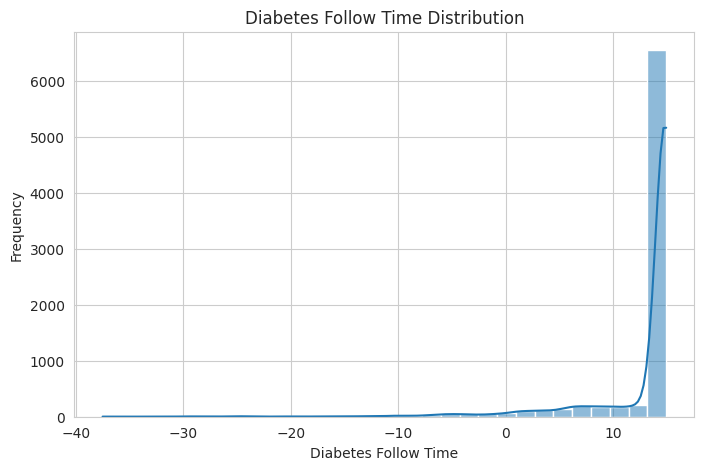

In [45]:
# BMI Distribution
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_df['diabetes_followup_time'], kde=True, bins=30)
plt.title('Diabetes Follow Time Distribution')
plt.xlabel('Diabetes Follow Time')
plt.ylabel('Frequency')
plt.show()

In [56]:
cleaned_df['diabetes_followup_time'].describe()

count    7979.000000
mean       12.959853
std         5.229209
min       -37.510000
25%        14.740000
50%        14.820000
75%        14.880000
max        14.960000
Name: diabetes_followup_time, dtype: float64

In [25]:
work_cols = ['BMI', 'age', 'sex', 'prevalent_diabetes', 'incident_diabetes', 'diabetes_followup_time']
work_df = cleaned_df[work_cols].copy()



In [ ]:
work_df

In [98]:
work_df.value_counts(['prevalent_diabetes', 'incident_diabetes'])

prevalent_diabetes  incident_diabetes
0.0                 0.0                  6993
                    1.0                   704
1.0                 0.0                   451
Name: count, dtype: int64

In [ ]:
work_df.loc[work_df['prevalent_diabetes']!=1, ]

In [101]:
work_df.loc[(work_df['incident_diabetes']!=0) & (work_df['prevalent_diabetes'] != 1),]

,BMI,age,sex,prevalent_diabetes,incident_diabetes,diabetes_followup_time
8,32.996551,32.73,1,0.0,1.0,7.88
18,31.328312,61.36,1,0.0,1.0,8.55
20,34.069880,56.79,0,0.0,1.0,6.49
26,28.360740,49.93,1,0.0,1.0,8.17
39,29.076581,53.01,1,0.0,1.0,6.46
...,...,...,...,...,...,...
8231,24.940660,64.00,0,NaN,NaN,NaN
8248,30.820480,44.38,1,0.0,1.0,5.52
8271,37.722910,61.76,0,0.0,1.0,3.23
8272,30.449827,49.00,1,0.0,1.0,11.79


In [95]:
work_df.loc[(work_df['incident_diabetes']!=0) & (work_df['prevalent_diabetes'] != 0),]

,BMI,age,sex,prevalent_diabetes,incident_diabetes,diabetes_followup_time
157,28.343070,50.0,0,NaN,NaN,NaN
186,31.036950,50.0,1,NaN,NaN,NaN
258,27.550591,62.0,0,NaN,NaN,NaN
303,23.137510,28.0,0,NaN,NaN,NaN
311,20.764110,32.0,1,NaN,NaN,NaN
313,26.203160,38.0,1,NaN,NaN,NaN
362,23.243410,45.0,0,NaN,NaN,NaN
376,22.769050,63.0,0,NaN,NaN,NaN
383,22.739960,30.0,0,NaN,NaN,NaN
394,20.530130,33.0,0,NaN,NaN,NaN


In [62]:
work_df.loc[(work_df['diabetes_followup_time']<=0) & (work_df['prevalent_diabetes'] != 1),]

,BMI,age,sex,prevalent_diabetes,incident_diabetes,diabetes_followup_time


In [63]:
work_df.loc[(work_df['diabetes_followup_time']<=0) & (work_df['incident_diabetes'] != 0),]

,BMI,age,sex,prevalent_diabetes,incident_diabetes,diabetes_followup_time


In [88]:
raw_df[['prevalent_diabetes', 'incident_diabetes']].value_counts()
# raw_df['prevalent_diabetes'].value_counts()

prevalent_diabetes  incident_diabetes
0.0                 0.0                  6993
                    1.0                   704
1.0                 0.0                   451
Name: count, dtype: int64

In [92]:
round((704 + 451) / raw_df.shape[0] * 100, 1)

13.9

In [32]:
cleaned_df.isna().mean(axis=1).sort_values()

7305    0.028966
4717    0.029793
7289    0.032000
5204    0.032276
7330    0.032276
          ...   
26      0.432000
25      0.467310
27      0.469517
24      0.472552
23      0.473379
Length: 8291, dtype: float64

In [30]:
work_df[work_cols]

,BMI,age,sex,prevalent_diabetes,incident_diabetes,diabetes_followup_time
0,18.664268,33.81,1,0.0,0.0,14.77
1,28.175977,68.56,1,0.0,0.0,14.77
2,22.971959,55.68,1,0.0,0.0,14.77
3,21.960370,43.89,0,0.0,0.0,14.78
4,40.454949,47.76,1,0.0,0.0,14.86
...,...,...,...,...,...,...
8286,22.170880,42.02,0,0.0,0.0,14.73
8287,33.632810,41.54,1,0.0,0.0,14.73
8288,25.497120,58.15,0,0.0,0.0,14.73
8289,24.075310,45.84,1,0.0,0.0,14.73


In [29]:
missing_rate_per_row[0]

0.0

In [59]:
pd.set_option('display.max_rows', 50)
work_df.loc[work_df[work_cols].isna().any(axis=1), ]

,BMI,age,sex,prevalent_diabetes,incident_diabetes,diabetes_followup_time
58,25.806009,68.39,1,1.0,0.0,NaN
70,29.000595,65.21,1,1.0,0.0,NaN
104,33.243191,66.55,0,1.0,0.0,NaN
127,34.179688,35.93,0,1.0,0.0,NaN
157,28.343070,50.00,0,NaN,NaN,NaN
167,21.542460,26.64,0,1.0,0.0,NaN
176,31.379130,53.17,1,1.0,0.0,NaN
186,31.036950,50.00,1,NaN,NaN,NaN
200,24.423595,67.99,1,1.0,0.0,NaN
203,43.355872,55.51,0,1.0,0.0,NaN


In [99]:
work_df.loc[work_df[['age', 'sex']].isna().any(axis=1), ]

,BMI,age,sex,prevalent_diabetes,incident_diabetes,diabetes_followup_time


# Statistical Analysis

## Univariate Logistic Regression for Each Biomarker

## Multiple Testing Correction

## Identify Significant Biomarkers

# Visualization of Significant Biomarkers

## Plot Top Significant Biomarkers

# Machine Learning Model

## Feature Selection

## Data Splitting

## Model Training

## Model Evaluation

### ROC AUC Score

### Classification Report

### Confusion Matrix

## ROC Curve

# Discussion

1. The study cohort has relative higher overall case rate (13.9%) at the end of follow-up period than general Americans in 2021 (11.6%) according to AHA (https://diabetes.org/about-diabetes/statistics/about-diabetes).

## Interpretation of Significant Biomarkers

## Model Performance

## Limitations

# Conclusion

# References